# Supernova Catalog: sne.space

Read the [sne.space supernova catalog](https://sne.space) by downloading the database in TSV format.

Details of how to access the data using URL gets are available in the [sne.space API docs on GitHub](https://github.com/astrocatalogs/OACAPI).

In [1]:
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=14)

## Download and Unpack Data

Access the supernova catalog using the [URL GET API](https://github.com/astrocatalogs/OACAPI). We want to download into tab-separated variable (TSV) format.

By downloading entries with redshifts we can cut down on the size of the download.

In [3]:
try:
    # Read a cached version of the catalog in TSV format.
    catalog = ascii.read('catalog_sne_redshift.tsv')
except FileNotFoundError as e:
    # If the catalog hasn't been downloaded yet, do so, then cache it on disk.
    import requests
    
    print(e)
    print('Downloading data from sne.space.')
    
    # Download the sne.space catalog using only data with redshifts.
    url = 'https://api.sne.space/catalog?format=TSV&redshift'
    r = requests.get(url)
    
    # Cache the data on disk.
    with open('catalog_sne_redshift.tsv', 'w') as f:
        f.write(r.text)

    # Load the cached data.
    catalog = ascii.read('catalog_sne_redshift.tsv')

# Select only values with the host, hostra, hostdec, redshift, ra, and dec fields.
select = ~((catalog['host'].mask) | 
           (catalog['hostra'].mask) |
           (catalog['hostdec'].mask) |
           (catalog['ra'].mask) |
           (catalog['dec'].mask))

catalog = catalog[select]
catalog

event,alias,catalog,claimedtype,dec,discoverdate,discoverer,download,ebv,host,hostdec,hostoffsetang,hostoffsetdist,hostra,instruments,lumdist,maxabsmag,maxappmag,maxdate,name,photolink,ra,radiolink,redshift,references,spectralink,velocity,xraylink
str59,str187,str3,str43,str146,str21,str116,str1,str13,str102,str72,str8,float64,str62,str478,float64,float64,float64,str10,str59,str19,str106,int64,str125,str99,str15,str14,int64
ASASSN-13dn,"ASASSN-13dn,CSS140102:125258+322506",sne,II,"+32:25:09.3,+32:25:05.16",2013/12/15,ASAS-SN,--,0.0129,SDSS J125258.03+322444.3,+32:24:44.3,21.42,10.19,12:52:58.03,--,102.68,-19.333,15.7,2013/12/14,ASASSN-13dn,"1,0","12:52:58.20,12:52:58.32",--,0.022805,"2013ATel.5665....1S,2016A&A...594A..13P,2013ATel.5667....1M,2011ApJ...737..103S",--,6758.8,--
ASASSN-14ad,ASASSN-14ad,sne,Ia,"+18:03:32.8,+18:03:32.76",2014/01/26,ASAS-SN,--,0.0159,"KUG 1237+183,SDSS J124011.38+180341.9",+18:03:41.9,9.85,5.4,12:40:11.38,"UVOT (W2, W1, M2, U, B, V)",119.2,-19.35,16.0,2014/02/01,ASASSN-14ad,"27,-4.87,4.11","12:40:11.10,12:40:11.04",--,0.0264,"2014Ap&SS.354...89B,2014ATel.5820....1P,2016A&A...594A..13P,2014ATel.5823....1Z,2011ApJ...737..103S",--,7810,--
ASASSN-14ax,ASASSN-14ax,sne,Ia,"+27:06:19.61,+27:06:19.6,+27:06:20.16",2014/05/04,ASAS-SN,--,0.0423,SDSS J171000.70+270619.6,+27:06:19.6,0.66,0.43,17:10:00.70,--,150.0,-19.3,16.5,2014/05/03,ASASSN-14ax,"1,0","17:10:00.700,17:10:00.70,17:10:00.72",--,0.033,"2014ATel.6133....1H,2016A&A...594A..13P,2014ATel.6143....1S,2011ApJ...737..103S",--,9700,--
ASASSN-14ay,ASASSN-14ay,sne,Ia,"+37:24:57.78,+37:24:57.8,+37:24:56.52",2014/05/19,ASAS-SN,--,0.0188,SDSS J155702.70+372500.0,+37:25:00.0,5.87,3.74,15:57:02.70,--,139.818,-19.4948,16.2,2014/05/18,ASASSN-14ay,"1,0","15:57:03.150,15:57:03.15,15:57:02.88",--,"0.030869,0.030847","2014ATel.6150....1D,2016A&A...594A..13P,2014ATel.6161....1O,2011ApJ...737..103S",--,9111.5,--
ASASSN-14az,"ASASSN-14az,Gaia14age,MLS140831:234448-020701",sne,IIb,"-02:07:03.17,-02:07:03.2,-02:07:01.488,-02:07:02.136,-02:07:01.344,-02:07:03.18",2014/05/20,ASAS-SN,e,0.0274,"PGC 1101367,GALEXASC J234448.27-020653.4",-02:06:53.4,8.94,1.28,23:44:48.27,"C, u, g, r, R, i",29.943,-16.734,15.64,2014/07/22,ASASSN-14az,"25,-36.1,67","23:44:48.000,23:44:48.00,23:44:48",--,0.006731,"2009ApJ...696..870D,2014ATel.6151....1D,2014ATel.6185....1B,2016A&A...594A..13P,2011ApJ...737..103S","1,-53.1",2011,--
ASASSN-14ba,ASASSN-14ba,sne,"Ia Pec,Ia-91T","+08:24:21.12,+08:24:21.1,+08:24:18.648",2014/05/19,ASAS-SN,--,0.0254,SDSS J102131.91+082419.8,+08:24:19.8,1.39,0.936,10:21:31.91,--,148.162,-19.2188,16.6,2014/05/18,ASASSN-14ba,"1,0","10:21:31.900,10:21:31.90,10:21:31.68,10:21:31.9",--,0.032668,"2014ATel.6152....1S,2014ATel.6189....1B,2016A&A...594A..13P,2011ApJ...737..103S","1,11.1",9633.7,--
ASASSN-14bb,"ASASSN-14bb,iPTF14axo",sne,Ia,"+38:39:40.8,+38:39:40.68,+38:39:39.96",2014/05/19,ASAS-SN,--,0.0134,2MASX J12141125+3839400,+38:39:40.0,0.84,0.39,12:14:11.25,"B, g, V, r, R, i, I, z",99.0,-20.0,14.95,2014/05/29,ASASSN-14bb,"130,-10.8,50.3","12:14:11.30,12:14:11.28",--,"0.022,0.023","2014ATel.6152....1S,2012PASP..124..668Y,2016A&A...594A..13P,2014ATel.6158....1F,2011ApJ...737..103S","1,-5.38",6500,--
ASASSN-14bu,ASASSN-14bu,sne,II,"+25:09:59.88,+25:09:59.9,+25:09:59.76",2014/05/29,ASAS-SN,--,0.0139,SDSS J111840.97+250958.5,+25:09:58.5,1.48,0.784,11:18:40.97,--,114.6,-18.17,17.1,2014/05/28,ASASSN-14bu,"1,0","11:18:41.030,11:18:41.03,11:18:41.04",--,0.0254,"2014ATel.6169....1B,2014ATel.6196....1D,2016A&A...594A..13P,2011ApJ...737..103S",--,7520,--
ASASSN-14cb,ASASSN-14cb,sne,Ia,"+62:02:00.9,+62:02:02.4",2014/06/07,ASAS-SN,--,0.0109,SDSS J130814.58+620201.2,+62:02:01.2,2.5,1.7,13:08:14.58,--,152.693,-19.1832,16.7,2014/06/06,ASASSN-14cb,"1,0","13:08:14.24,13:08:14.4",--,0.033643,"2014ATel.6219....1H,2016A&A...594A..13P,2014ATel.6218....1C,2011ApJ...737..103S",--,9916.4,--


## List Classification

There are classifications of the spectra made manually and automatically.

The lines below are a bit of Python kung-fu to grab the `claimedtype` field in the supernova database and spit out the list of possible classifications. We will need to decide later which kind of SNe we want to keep and which we want to throw away.

Note that Type Ia supernovae occur in binary stars and are a fundamentally different mechanism than core-collapse supernovae. We are interested in the core-collapse supernovae, not the Type Ia.

In [4]:
# Get a unique list of all the claimed object types in the catalog.
claimedtype = np.unique(','.join([str(_) for _ in catalog['claimedtype']]).split(','))
claimedtype

array(['--', '.IIP', '.Ia', '.IaPec', 'AGN', 'AGN?', 'BL-Ic', 'CC',
       'Ca-rich', 'Candidate', 'Comet', 'Core-Collapse', 'Galaxy', 'I',
       'I Pec', 'I-faint', 'I-rapid', 'I?', 'II', 'II L', 'II P',
       'II P Pec', 'II P pec', 'II P-97D', 'II P?', 'II Pec', 'II Pec?',
       'II-P/L', 'II-Pp.', 'II-p', 'II/IIb', 'II/Ib', 'II/Ic', 'II?',
       'IIL/IIn', 'IIP/IIL', 'IIb', 'IIb Pec', 'IIb/Ib', 'IIb/Ib/Ic',
       'IIb/Ib/Ic (Ca rich)', 'IIc', 'IIn', 'IIn L', 'IIn P', 'IIn Pec',
       'IIn-pec/LBV', 'IIn/Ibn', 'IIn/LBV', 'IIn?', 'Ia', 'Ia CSM',
       'Ia Pec', 'Ia Pec?', 'Ia(N)', 'Ia*', 'Ia-02cx', 'Ia-09dc',
       'Ia-91T', 'Ia-91bg', 'Ia-92bg', 'Ia-HV', 'Ia-SC', 'Ia-pec.',
       'Ia/Ic', 'Ia/Ic?', 'Ia/c', 'Ia/c?', 'Ia?', 'Ia? P?', 'IaPec(N)',
       'Iax[02cx-like]', 'Ib', 'Ib (Ca rich)', 'Ib Pec', 'Ib-Ca',
       'Ib-Ca-rich', 'Ib-n/IIb-n', 'Ib-pec/Iax', 'Ib/IIb', 'Ib/Ic',
       'Ib/Ic (Ca rich)', 'Ib/Ic (Ca rich?)?', 'Ib/c', 'Ib/c Pec',
       'Ib/c-BL', 'Ib/c?', 'Ib?',

## Example Plot of SN Ia

This selects out all supernovae that match the Type Ia classification (`claimedtype`) and plots their sky coordinates.

In [5]:
select_Ia = catalog['claimedtype'] == 'Ia'
hostra = catalog[select_Ia]['hostra']
hostdec = catalog[select_Ia]['hostdec']

hostra = [_.split(',')[0] if ',' in _ else _ for _ in hostra]
hostdec = [_.split(',')[0] if ',' in _ else _ for _ in hostdec]

coords = SkyCoord(ra=hostra, dec=hostdec, unit=(u.hourangle, u.degree), frame='icrs')

### Function to Plot RA, Dec

In [6]:
def plot_radec(ra, dec, sizes=10):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    ra : pandas.Series or list
        List of candidate RA [deg].
    dec : pandas.Series or list
        List of candidate Dec [deg].
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    # Convert RA, Dec to radians.
    # Rotate the RA so that the plot goes 360->0 left to right.
    _ra = np.radians(180. - ra)
    _dec = np.radians(dec)

    fig, ax = plt.subplots(1,1, figsize=(10,5), subplot_kw={'projection': 'mollweide'})
    ax.scatter(_ra, _dec, s=sizes, alpha=0.5)
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    fig.tight_layout()
    
    return fig;

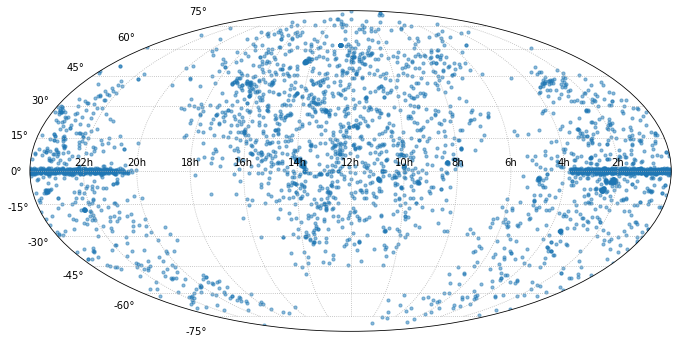

In [7]:
fig = plot_radec(coords.ra.value, coords.dec.value)